## Libraries and Environment

In [ ]:
# to run in google colab
# import sys
# if 'google.colab' in sys.modules:
#     import subprocess
#     subprocess.call("pip install -U opencv-python".split())

In [ ]:
!pip install -U opencv-contrib-python

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import heapq
import cv2
from tqdm.notebook import tqdm, trange

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import CIFAR10 Dataset

In [ ]:
# function for unpickling the CIFAR10 dataset
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

Note: Each row of the "images" array produced below stores one of the 60,000 32x32 color images. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.

In [ ]:
# import CIFAR10 image batches
DATA_ROOT = "/content/drive/Shareddrives/504 Project/CIFAR10/cifar-10-batches-py/"
batch1 = unpickle(DATA_ROOT + "data_batch_1")
batch2 = unpickle(DATA_ROOT + "data_batch_2")
batch3 = unpickle(DATA_ROOT + "data_batch_3")
batch4 = unpickle(DATA_ROOT + "data_batch_4")
batch5 = unpickle(DATA_ROOT + "data_batch_5")
test_batch = unpickle(DATA_ROOT + "test_batch")

images = np.concatenate([batch1[b'data'], batch2[b'data'], batch3[b'data'], batch4[b'data'], batch5[b'data'], test_batch[b'data']])

# confirm correct size of data array
print("Data dimensions: ", np.shape(images))

Data dimensions:  (60000, 3072)


In [ ]:
images_tupled = []

for i, img in enumerate(images):
  images_tupled.append((i, img))

In [ ]:
def cifar10_plot_single(data, im_idx=0):
    im = data[im_idx, :]
    
    im_r = im[0:1024].reshape(32, 32)
    im_g = im[1024:2048].reshape(32, 32)
    im_b = im[2048:].reshape(32, 32)

    img = np.dstack((im_r, im_g, im_b))

    print("shape: ", img.shape)        
    
    plt.imshow(img) 
    plt.show()

## Locality hashing

basing off: https://github.com/kayzhu/LSHash/blob/master/lshash/lshash.py

and



Remember to cite eventually....

In [ ]:
#from IPython.core.display import display_javascript
class LocalityHash:

  def __init__(self, hash_size, input_dim, num_tables = 1):
      
      """
        arg input_dim: the expected dimension of the data to be hashed
        arg hash_size: number of random hyperplanes that divide the space into hash buckets
        
        Info: What we are realy storing for hyperplanes is the norm of the planes, initialized randomly with standard normal distribution. 
        Points whose dot product with the norm have the same sign are on the same side of the plane.
      """
      self.hash_size = hash_size
      self.input_dim = input_dim
      self.num_tables = num_tables

      self.planes = [np.random.randn(self.hash_size, self.input_dim) for _ in range(self.num_tables)]
      self.hash_tables = [{} for _ in range(self.num_tables)]

      print("LSH initialized")
      print("Number of hash tables: {}".format(self.num_tables))
      print("Number of hyperplanes per table: {}".format(self.hash_size))
      print("Number of buckets per table: {}".format(2**(self.hash_size)))
  
  def get_hashkey(self, plane, input_point):

    """ 
      arg input point dimension = 1* input_dim

      Takes an input point and generates a hash key based on its location relative to the hyperplanes (In which bucket)
      Returns a binary string map of length self.hash_size (number of hyperplanes) where 1 = "above" hyperplane i and 0 = "below" hyperplane i
      looks like: "101010100"

    """
    location_projections = np.dot(plane, input_point)
        
        #if dot product of input point and hyper plane is positive, its 'above' in n-d space, if negative or 0, below
    hash_key = "".join(['1' if i > 0 else '0' for i in location_projections])

    return hash_key


  def insert_point(self, input_point, original_index):

    """
      arg input_point dimension = 1* input_dim
      arg original_index = reference to the index of the full size image for retrieval
    """

    info = (tuple(input_point.tolist()), original_index)  #save point as tuple to save memory
    
    for i, hash_table in enumerate(self.hash_tables):
      key = self.get_hashkey(self.planes[i], input_point)

      if key in hash_table:
          hash_table[key].append(info)
      else:
          hash_table[key] = [info]

  
  def initialize(self, input_data, verbose = False):
    if input_data[0][1].shape[0] != self.input_dim:
        print("Input points should have dimension: 1 x {}".format(self.input_dim))
        return

    print("Initializing LSH from data...")

    for data in input_data:
      index, point = data
      self.insert_point(point, index)

    if verbose:
      count_str = "\nInserted:\n"
      for i, hash_table in enumerate(self.hash_tables):
        for bucket, item in hash_table.items():
            count_str += "{} items into bucket {} in hash table {}".format(str(len(item)), bucket, str(i+1))
            count_str += "\n"
        count_str += "\n"

      print(count_str)



  def get_knns(self, query_point, k):
      
      candidates = set()

      for i, table in enumerate(self.hash_tables):
          key = self.get_hashkey(self.planes[i], query_point)
          if key in table:
            candidates.update(table[key])

      if len(candidates) <= 1:  #if query returns nothing or just the query point itself, return
        if len(candidates) == 0 or (tuple(candidates[0][0]) == tuple(query_point.tolist())):
          print("No neighbors found")
          return
    
      #add eucledian:
      candidates_aug = []
      for i, (point, index) in enumerate(candidates):
          dist = np.linalg.norm(np.array(point) - query_point)
          candidates_aug.append((point, index, dist))
      
      #sort on eucledian
      candidates_aug.sort(key=lambda x: x[2])

      ##trim if duplicates/remove same value:
      smallest_dist = candidates_aug[0][2]
      i = 0
      while i < len(candidates_aug) and smallest_dist == 0:
        candidates_aug = candidates_aug[i+1:]
        smallest_dist = candidates_aug[0][2]

      if len(candidates_aug) <= k:
        return candidates_aug
      else:
        return candidates_aug[:k]



In [ ]:
lsh = LocalityHash(hash_size= 10, input_dim = images.shape[1], num_tables = 25)

LSH initialized
Number of hash tables: 25
Number of hyperplanes per table: 10
Number of buckets per table: 1024


In [ ]:
images_subset = images_tupled[:50000]
images_unseen = images_tupled[50000:]

In [ ]:
lsh.initialize(images_tupled)

Initializing LSH from data...


In [ ]:
test_img = images_tupled[0][1]
test_idx = images_tupled[0][0]
knn = lsh.get_knns(test_img,20)

In [ ]:
def get_neighbor_indexes(knns):
  indexes = []
  for n in knns:
    indexes.append(n[1])
  return indexes


In [ ]:
def display_indexes_dist(knns):
  
  for n in knns:
    print("Neighbor at idx {}, distance {}".format(n[1], round(n[2],4)))


In [ ]:
display_indexes_dist(knn)

Neighbor at idx 48216, distance 2255.3264
Neighbor at idx 45702, distance 2268.1561
Neighbor at idx 47631, distance 2281.878
Neighbor at idx 35877, distance 2296.4928
Neighbor at idx 58958, distance 2306.4249
Neighbor at idx 42549, distance 2331.8263
Neighbor at idx 43118, distance 2333.6853
Neighbor at idx 59456, distance 2337.8325
Neighbor at idx 57256, distance 2344.6211
Neighbor at idx 16244, distance 2353.2305
Neighbor at idx 57408, distance 2353.2622
Neighbor at idx 5017, distance 2370.6921
Neighbor at idx 48447, distance 2372.6569
Neighbor at idx 13972, distance 2375.3911
Neighbor at idx 51350, distance 2389.9031
Neighbor at idx 14060, distance 2415.2331
Neighbor at idx 44207, distance 2421.8565
Neighbor at idx 19420, distance 2424.3292
Neighbor at idx 57171, distance 2431.2394
Neighbor at idx 9980, distance 2431.6924


In [ ]:
n1 = knn[0]
n2 = knn[1]
n3 = knn[2]
n4 = knn[3]

shape:  (32, 32, 3)


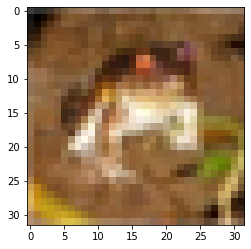

In [ ]:
cifar10_plot_single(images, im_idx=test_idx)

shape:  (32, 32, 3)


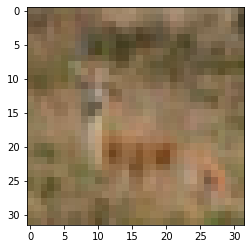

In [ ]:
cifar10_plot_single(images, im_idx=n1[1])

shape:  (32, 32, 3)


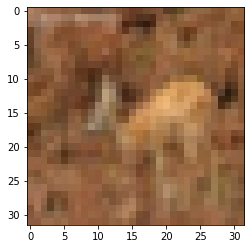

In [ ]:
cifar10_plot_single(images, im_idx=n2[1])

shape:  (32, 32, 3)


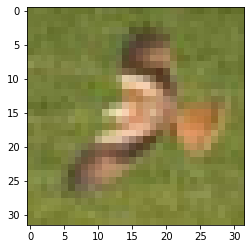

In [ ]:
cifar10_plot_single(images, im_idx=n3[1])

### Test LSH with small dim data

In [ ]:
lsh = LocalityHash(hash_size= 2, input_dim = 8, num_tables = 2)

In [ ]:
print(lsh.planes)

[array([[ 0.50005523, -0.58111365,  2.65604667, -2.56595148,  0.09030725,
        -0.55184139,  1.20032336, -0.02177128]])]


In [ ]:
dummy_data = np.array([np.array([1,0,5,4,3,2,8,1]), np.array([0.5,-0.5,3,4,5,1,9,5]), np.array([-0.25,-0.9,4,3,2,4,9,7]), np.array([0.7,0.6,6,5,4,2,7,8])])

In [ ]:
lsh.initialize(dummy_data)

Initializing LSH from data...
Input data shape: (4, 8)

Inserted:
4 items into bucket 01 in hash table 1

3 items into bucket 00 in hash table 2
1 items into bucket 10 in hash table 2




In [ ]:
print(lsh.get_hashkey(lsh.planes[0],dummy_data[0]))

11


In [ ]:
knn = lsh.get_knns(dummy_data[0], 2)

In [ ]:
print(knn)

[((0.5, -0.5, 3.0, 4.0, 5.0, 1.0, 9.0, 5.0), 1, 5.1478150704935), ((-0.25, -0.9, 4.0, 3.0, 2.0, 4.0, 9.0, 7.0), 2, 6.809735677689701)]


In [ ]:
knn = lsh.get_knns(dummy_data[0], 4)

In [ ]:
print(knn)

[((0.5, -0.5, 3.0, 4.0, 5.0, 1.0, 9.0, 5.0), 1, 5.1478150704935), ((-0.25, -0.9, 4.0, 3.0, 2.0, 4.0, 9.0, 7.0), 2, 6.809735677689701), ((0.7, 0.6, 6.0, 5.0, 4.0, 2.0, 7.0, 8.0), 3, 7.310950690573696)]


## Populate Each Data Structure with CIFAR10 Data

## Test Search Query Performance

In [ ]:
# search query should likely reduce the feature vector of the given query image in
# the same way in which the CIFAR10 and search the structure using that vector


# true nearest neighbors for images can be calculated using the L2 distance between images,
# which will be needed for comparing the performance of both structures in terms of accuracy